จำนวนข้อมูลที่ขาดหายในแต่ละคอลัมน์:
Date         199
Open         197
High         161
Low          182
Close        161
Adj Close    161
Volume       187
dtype: int64

ตัวอย่าง Input (Features):
       Open      High       Low       Volume  Year  Month  Day
0  1.266667  1.666667  1.169333  281494500.0  2010      6   29
1  1.719333  2.028000  1.553333  257806500.0  2010      6   30
2  1.666667  1.728000  1.351333  123282000.0  2010      7    1
3       NaN  1.540000  1.247333   77097000.0  2010      7    2
4  1.333333  1.333333  1.055333  103003500.0  2010      7    6

ตัวอย่าง Output (Target):
0    1.592667
1    1.588667
2    1.464000
3         NaN
4    1.074000
Name: Close, dtype: float64

โมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!


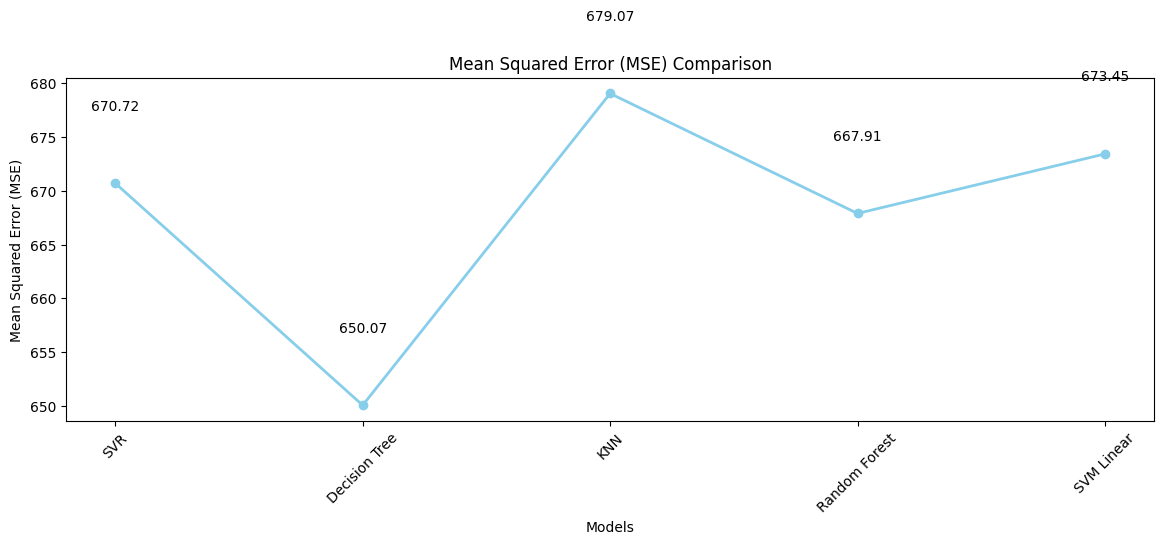

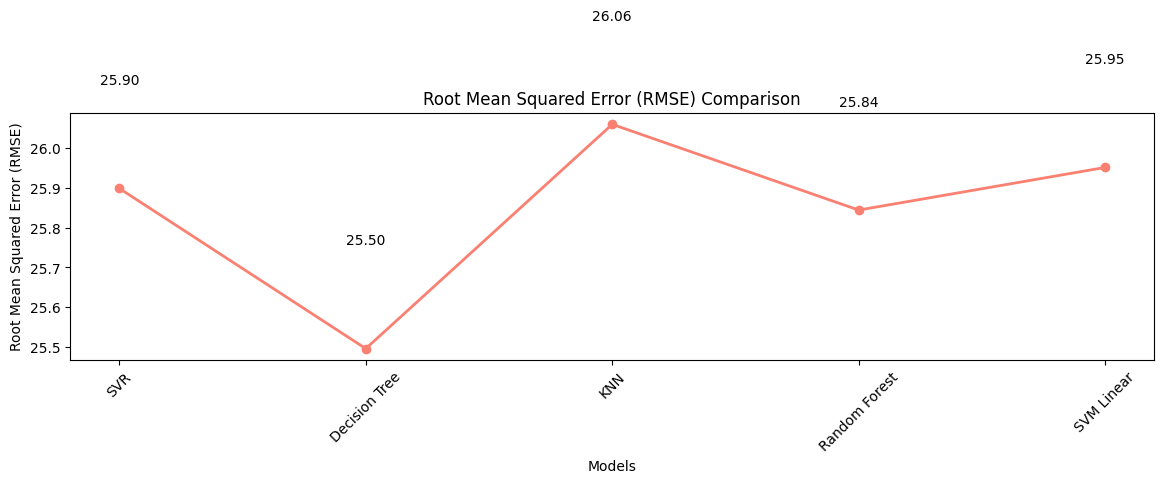

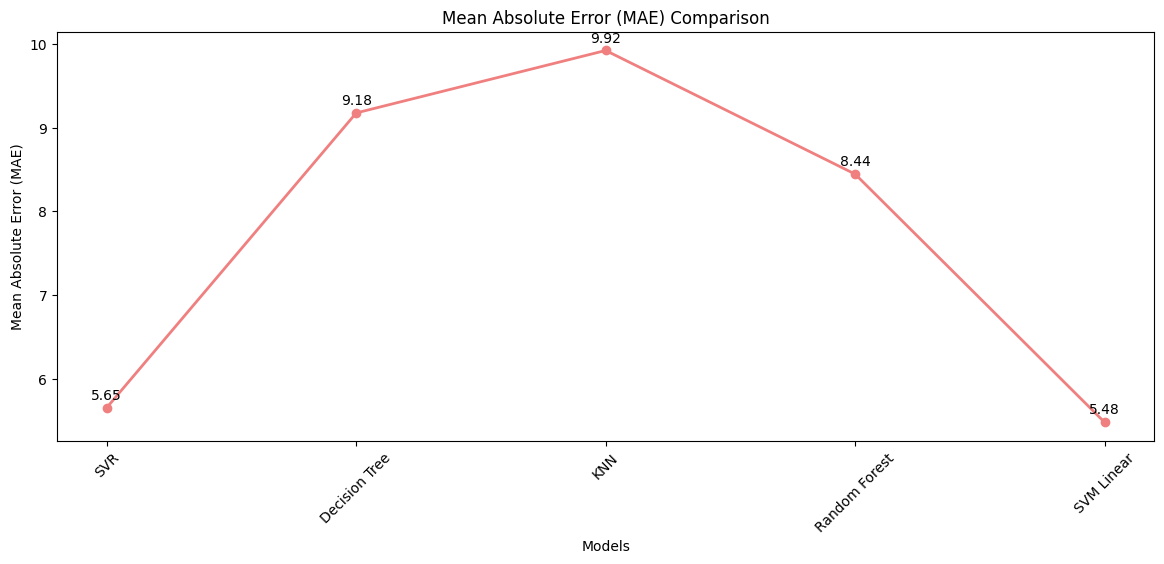

<ipython-input-7-4157f3db6cee>:156: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0)  # เพิ่ม padding เพื่อให้มีระยะห่างมากขึ้น


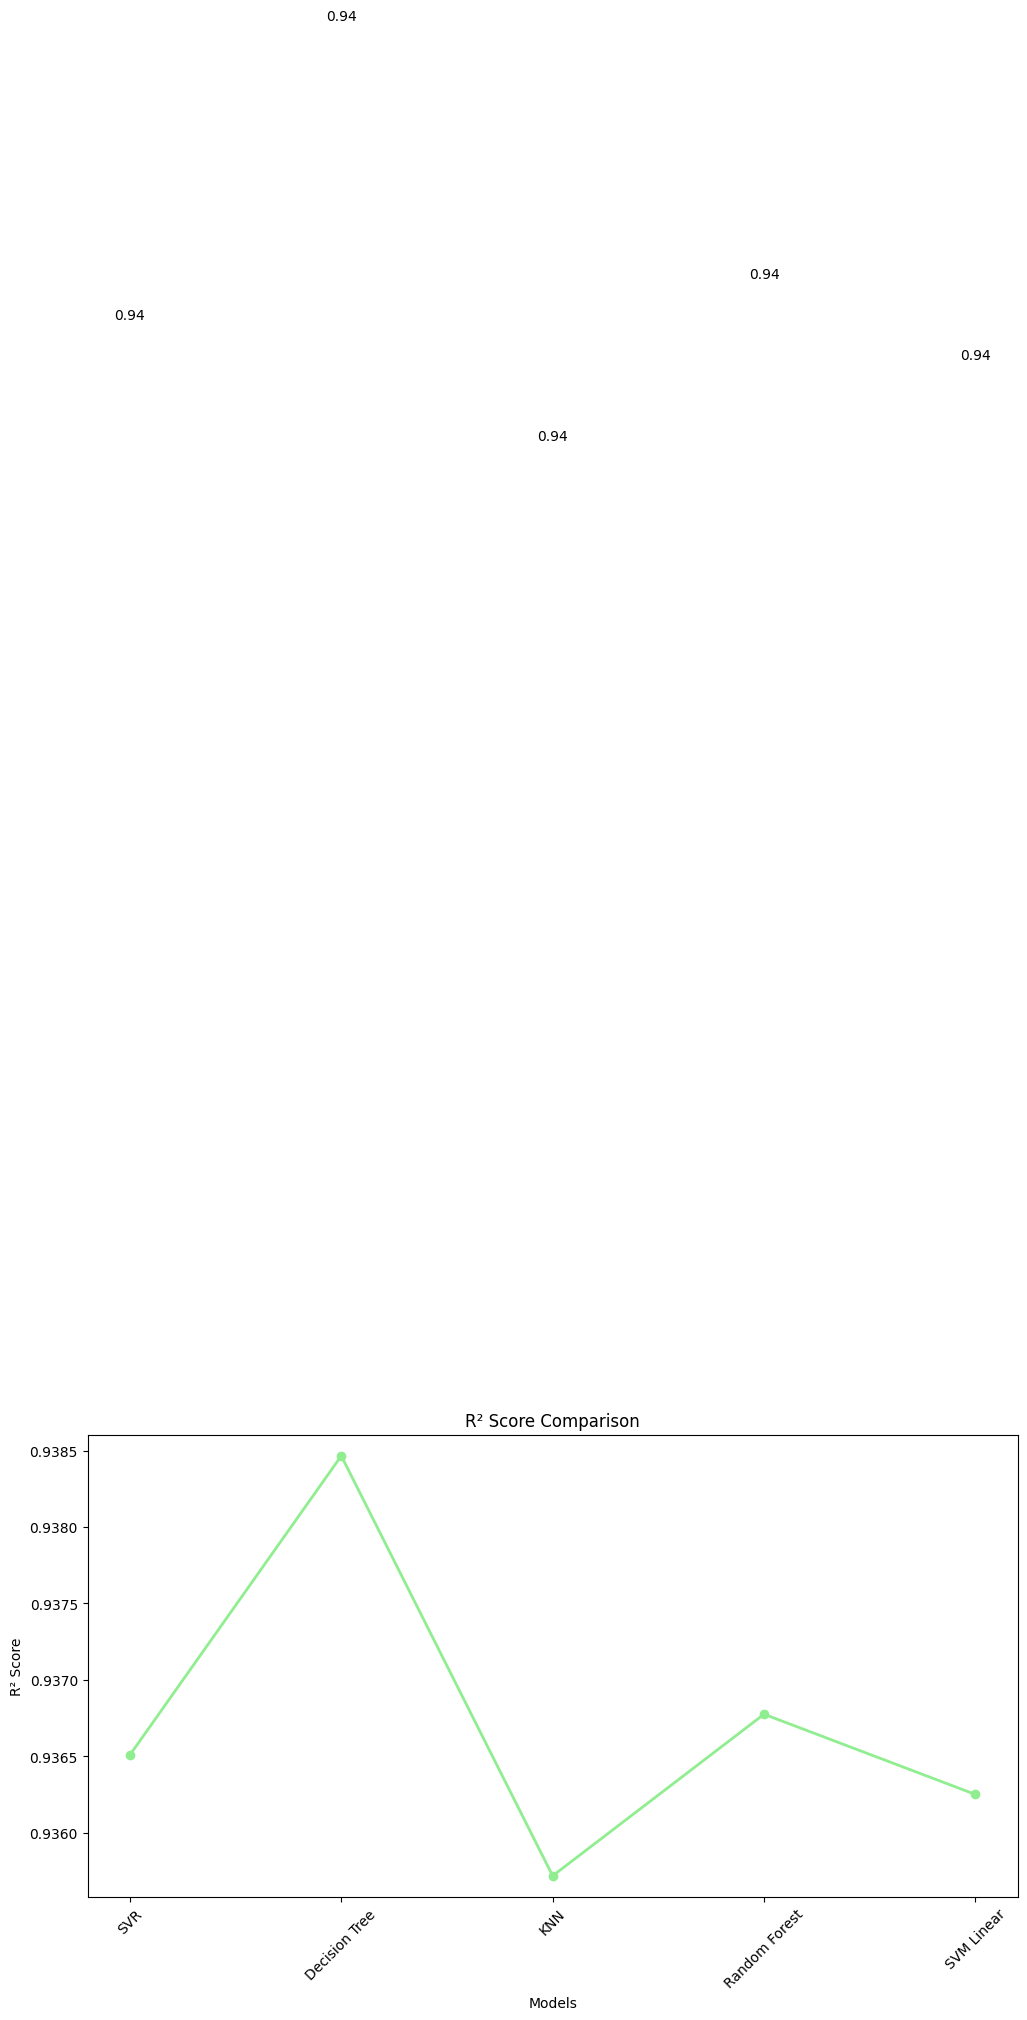

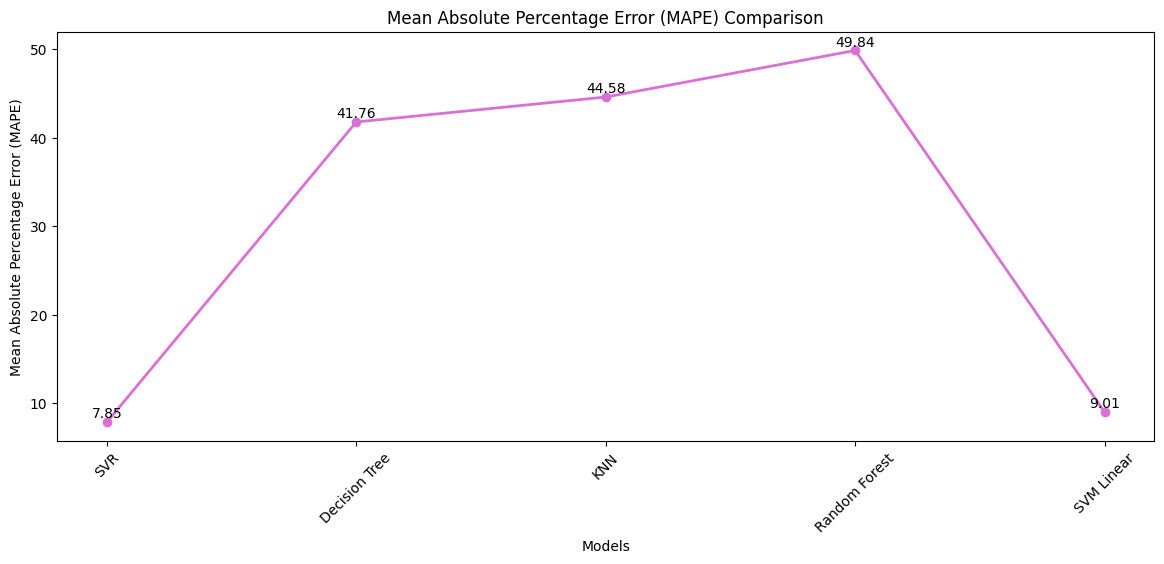

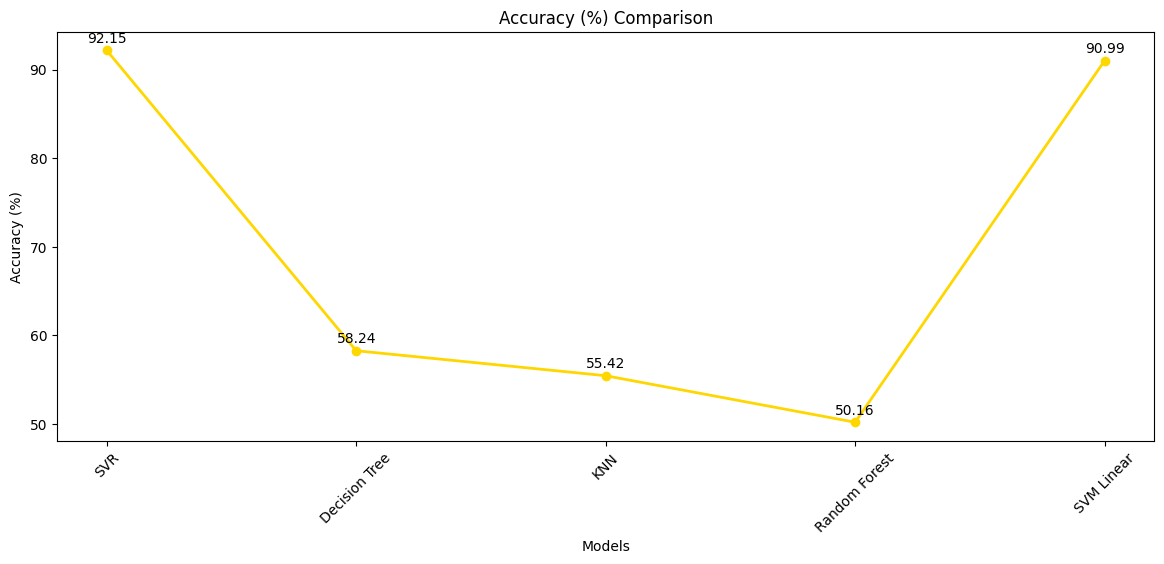


Model Comparison:
           Model         MSE       RMSE       MAE        R²   MAPE (%)  \
1  Decision Tree  650.066223  25.496396  9.175000  0.938465  41.762754   
3  Random Forest  667.907320  25.843903  8.444062  0.936776  49.841602   
0            SVR  670.719475  25.898252  5.653614  0.936510   7.849842   
4     SVM Linear  673.446178  25.950842  5.478725  0.936252   9.010471   
2            KNN  679.067532  26.058924  9.921435  0.935720  44.584164   

   Accuracy (%)  
1     58.237246  
3     50.158398  
0     92.150158  
4     90.989529  
2     55.415836  

ผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance_stock.csv' เรียบร้อยแล้ว!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

# โหลดข้อมูลจากไฟล์ CSV
df = pd.read_csv("/content/TeslaDetaset_with_missing_values.csv")  # แก้ชื่อไฟล์ให้ถูกต้อง

# ตรวจสอบข้อมูลที่ขาดหาย
print("จำนวนข้อมูลที่ขาดหายในแต่ละคอลัมน์:")
print(df.isnull().sum())

# แปลง Date เป็น string และจัดการค่า NaN
df['Date'] = df['Date'].astype(str)  # แปลงเป็น string ก่อน
df = df[df['Date'] != 'nan']  # ลบแถวที่ Date เป็น 'nan' (หลังแปลงเป็น string)

# แยก Date เป็น Year, Month, Day
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))
df['Day'] = df['Date'].apply(lambda x: int(x.split('-')[2]))

# กำหนด Input (Features) และ Output (Target)
features = ['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day']  # ใช้เฉพาะ features ที่ต้องการ
X = df[features]  # Input
y = df['Close']   # Output (เป้าหมาย)

print("\nตัวอย่าง Input (Features):")
print(X.head())
print("\nตัวอย่าง Output (Target):")
print(y.head())

# จัดการ Missing Values ด้วย KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)

# ลบแถวที่มี NaN หลัง imputation
mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# ตรวจสอบ outliers และตัดทิ้ง
def remove_outliers(df_col):
    z_scores = (df_col - df_col.mean()) / df_col.std()
    return df_col[abs(z_scores) < 3]

for col in X_imputed.columns:
    X_imputed[col] = remove_outliers(X_imputed[col])
y_imputed = remove_outliers(y_imputed)

mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ฝึกโมเดล SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)

# ฝึกโมเดล Decision Tree
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

# ฝึกโมเดล KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

# ฝึกโมเดล Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# ฝึกโมเดล SVM Linear
svm_reg = SVR(kernel='linear')
param_grid_svm = {'C': [10, 50, 100], 'epsilon': [0.01, 0.1, 0.5]}
grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_r2 = r2_score(y_test, y_pred_svm)

# บันทึกโมเดลเป็นไฟล์ .pkl
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(best_svr, f)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('svm_linear_model.pkl', 'wb') as f:
    pickle.dump(best_svm, f)
print("\nโมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!")

# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]
y_preds = [y_pred_svr, y_pred_dt, y_pred_knn, y_pred_rf, y_pred_svm]

# คำนวณ RMSE, MAE, MAPE และ Accuracy
rmse_scores = [np.sqrt(mse) for mse in mse_scores]
mae_scores = [mean_absolute_error(y_test, y_pred) for y_pred in y_preds]
mape_scores = [np.mean(np.abs((y_test - y_pred) / y_test)) * 100 for y_pred in y_preds]
accuracy_scores = [100 - mape for mape in mape_scores]

# ฟังก์ชันสำหรับพลอตกราฟ
def plot_metric(metric_name, metric_values, color):
    plt.figure(figsize=(12, 6))  # เพิ่มขนาดกราฟจาก (10, 5) เป็น (12, 6)
    plt.plot(models, metric_values, marker='o', color=color, linestyle='-', linewidth=2)
    plt.title(f'{metric_name} Comparison')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    for i, v in enumerate(metric_values):
        plt.text(i, v + max(metric_values) * 0.01, f'{v:.2f}', ha='center')  # ลดระยะห่างจาก 0.02 เป็น 0.01
    plt.tight_layout(pad=2.0)  # เพิ่ม padding เพื่อให้มีระยะห่างมากขึ้น
    plt.show()

# พลอตกราฟ
plot_metric('Mean Squared Error (MSE)', mse_scores, 'skyblue')
plot_metric('Root Mean Squared Error (RMSE)', rmse_scores, 'salmon')
plot_metric('Mean Absolute Error (MAE)', mae_scores, 'lightcoral')
plot_metric('R² Score', r2_scores, 'lightgreen')
plot_metric('Mean Absolute Percentage Error (MAPE)', mape_scores, 'orchid')
plot_metric('Accuracy (%)', accuracy_scores, 'gold')

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores,
    'MAPE (%)': mape_scores,
    'Accuracy (%)': accuracy_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

# บันทึกผลลัพธ์เป็นไฟล์ CSV
results.to_csv('model_performance_stock.csv', index=False)
print("\nผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance_stock.csv' เรียบร้อยแล้ว!")